# Abstractive Text Summarization Using RNN

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## Module Imports

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import os
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from matplotlib import pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import glob
import itertools
import pickle
import re
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
!pip install rouge-score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=36e444ae5ad6abd591b3b709609fb28efd5f4a6b99cf286e7f30a31297532d47
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


Mounting the goodle drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read Data and Data Preprocessing

In [ ]:
train_path = '/content/drive/MyDrive/DLProject/cnn_dailymail/train.csv'
test_path = '/content/drive/MyDrive/DLProject/cnn_dailymail/test.csv'
val_path = '/content/drive/MyDrive/DLProject/cnn_dailymail/validation.csv'

# Load datasets
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
val_data = pd.read_csv(val_path)

In [ ]:
# Splitting train data
X_Train = train_data['article'].values[:100000]
Y_Train = train_data['highlights'].values[:100000]

# Splitting test data
X_Test = test_data['article'].values
Y_Test = test_data['highlights'].values

# Splitting validation data
X_Val = val_data['article'].values
Y_Val = val_data['highlights'].values

## Constants

Settign the basic constants here that will be golbally used across the program

In [ ]:
drive_prefix = '/content/drive/MyDrive/DLProject/cnn_dailymail/'


# STOP_WORDS = set(stopwords.words('english'))
STOP_WORDS = set()
EMB_SIZE = 300
GLOVE_EMB = '/content/drive/My Drive/DLProject/glove.6B.300d.txt'
BATCH_SIZE = 32
EPSILON = 0.5 # for deciding between feeding (model's output OR target) as input

START_CHAR = 'starttoken'
END_CHAR = 'endtoken'
PAD_CHAR = 'padtoken'

MAX_ARTICLE_LEN = 300 # the article can have at most 300 tokens
MAX_DECODER_OUTPUT = 100 # labels can have at most 100 tokens

# NN Hyper-parameters
E_HIDDEN_DIM = 200
D_HIDDEN_DIM = 200

EP = 4400
PRINT_EVERY_EP = 100
SAVE_MODEL_EVERY_EP = 5000
FORCE_CREATE_DICT = True # force to recreate the word features from scratch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()

cuda


## Helper Functions

- `clean_text(s)`: Cleans the input text by converting it to lowercase, removing specified HTML tags, unwanted characters, and punctuation, and standardizing whitespace.
- `create_word_vec(input_text, input_label, force_create)`: Creates word embeddings from pre-trained GloVe vectors for unique tokens found in `input_text` and `input_label`, managing dictionaries for word-to-index and index-to-word mappings, and handling embedding file storage.
- `sentence_to_idx(sentence, word_to_idx)`: Converts a sentence into a list of indices based on a provided word-to-index dictionary.
- `decontracted(text)`: Processes text by expanding contractions (e.g., turning "can't" into "cannot") and cleaning up non-alphanumeric characters.
- `pre_process(column, max_len)`: Pre-processes a column of text data by cleaning, reducing each entry to a specified maximum length, and converting to lowercase.
- `zeroPadding(l, fillvalue=PAD_CHAR)`: Pads a list of sequences to the length of the longest sequence using a specified padding character.
- `binaryMatrix(l, value=PAD_CHAR)`: Creates a binary matrix for a list of sequences, where each position is 1 if the token is not the padding character and 0 otherwise.
- `plot(train_loss, val_loss)`: Plots training and validation loss over time, providing a visual representation of the model's learning progress.

In [ ]:
def clean_text(s):
    s = s.lower().strip()
    s = s.replace('<t>', '').replace('</t>', '').replace('\n', '')
    s = s.replace('-lrb-', '').replace('-rrb-', '')
    s = re.sub(r'\([^)]*\)', '', s)
    s = re.sub('"','', s)
    s = re.sub(r"'s\b","",s)
    s = re.sub("[^a-zA-Z]", " ", s)
    # s = re.sub(r"([.!?])", r" \1", s)
    # s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


def create_word_vec(input_text, input_label, force_create):
    word_idx_dict = {} # { word : the index of that word in the dictionary}
    idx_word_dict = {} # { index of word : word }

    # 1. Create mapping between words and the corresponding embedding values
    embed_file_path = drive_prefix + f'{EMB_SIZE}d_embed_dict'
    if os.path.exists(embed_file_path) and not force_create:
        print('Embedding dictionary exists, loading from file...')
        embedding_dict = pickle.load(open(embed_file_path, 'rb'))
    else:
        embedding_dict = {}

        for line in glove:
            tokens = line.split()
            embedding_dict[tokens[0]] = np.array(tokens[1:], dtype='float32')
        pickle.dump(embedding_dict, open(embed_file_path, 'wb'))
        print('Saved embedding dictionary')

    # 2. Tokenize the input_text and labels
    if os.path.exists(drive_prefix + 'train_word_idx_dict') and not force_create:
        print('Word-to-index dictionary exists, loading from file...')
        word_idx_dict = pickle.load(open(drive_prefix + 'train_word_idx_dict', 'rb'))
    if os.path.exists(drive_prefix + 'train_idx_word_dict') and not force_create:
        print('Index-to-word dictionary exists, loading from file...')
        idx_word_dict = pickle.load(open(drive_prefix + 'train_idx_word_dict', 'rb'))
    else:
        unique_tokens = set([])
        for line in input_text:
            unique_tokens = unique_tokens.union(word_tokenize(line))
        for line in input_label:
            unique_tokens = unique_tokens.union(word_tokenize(line))

        for token in unique_tokens:
            word_idx_dict[token] = len(word_idx_dict)

        # 2.1 Add in the special tokens to the dictionary, note that the START_CHAR and END_CHAR have been added
        # during the preprocessing stage
        word_idx_dict[PAD_CHAR] = len(word_idx_dict)

        idx_word_dict = dict(zip(word_idx_dict.values(), word_idx_dict.keys()))

    # 3. Build the word vector for all the words in our dictionary
    if os.path.exists(drive_prefix + 'train_word_vector') and not force_create:
        print('Word Vector exists, loading from file...')
        word_vector = pickle.load(open(drive_prefix + 'train_word_vector', 'rb'))
    else:
        word_vector = []
        for idx, token in idx_word_dict.items():
            if token in embedding_dict:
                word_vector.append(embedding_dict[token])
            # Append the special tokens to the word vector and assign random values
            elif token in [START_CHAR, END_CHAR, PAD_CHAR]:
                word_vector.append(np.random.normal(0, 1, EMB_SIZE))
            # if the token doesn't have an embedding, we set to 0
            else:
                word_vector.append(np.zeros([EMB_SIZE]))

    ## Save the dictionaries
    pickle.dump(word_idx_dict, open(drive_prefix + 'train_word_idx_dict', 'wb'))
    pickle.dump(idx_word_dict, open(drive_prefix + 'train_idx_word_dict', 'wb'))
    pickle.dump(word_vector, open(drive_prefix + 'train_word_vector', 'wb'))

    # The index in word_vec corresponds to the article index in the original X_Test array
    return np.array(word_vector), word_idx_dict, idx_word_dict

def sentence_to_idx(sentence, word_to_idx):
    tokens = word_tokenize(sentence)
    return [word_to_idx[token] for token in tokens if token in word_to_idx]

def decontracted(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    return text

def pre_process(column, max_len):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentence in tqdm(column.astype(str)):
        sent = decontracted(sentence)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", sent)
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent=re.sub('<[^>]*>', '', sent)
        # trim longer articles
        sent = sent.lower().strip()
        sent = ' '.join(sent.split()[:max_len])
        preprocessed_text.append(sent)
    return preprocessed_text

## TODO: REFERENCE
def zeroPadding(l, fillvalue=PAD_CHAR):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_CHAR):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_CHAR:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

def plot(train_loss, val_loss):
    plt.plot(train_loss, label='Train')
    plt.plot(val_loss, label='Val')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Episodes')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Reading the glove embeddings

In [ ]:

with open(GLOVE_EMB, 'r', encoding='utf-8') as f:
    glove = f.readlines()

In [ ]:
#sanity check
X_Test[0]

"Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk. They say that the shrinking space on aeroplanes is not only uncomfortable - it's putting our health and safety in danger. More than squabbling over the arm rest, shrinking space on planes putting our health and safety in danger? This week, a U.S consumer advisory group set up by the Department of Transportation said at a public hearing that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. 'In a world where animals have more rights to space and food than humans,' said Charlie Leocha, consumer representative on the committee.\xa0'It is time that the DOT and FAA take a stand for humane treatment of passengers.' But could crowding on planes lead to more serious issues than fighting for sp

In [ ]:
#Train and Validation split
X_Test = pre_process(np.array(X_Test), max_len=MAX_ARTICLE_LEN)
Y_Test = pre_process(np.array(Y_Test), max_len=MAX_DECODER_OUTPUT)
Y_Test = list(map(lambda x: f"{START_CHAR} {x} {END_CHAR}", Y_Test))

X_Test, X_Val, Y_Test, Y_Val = train_test_split(X_Test, Y_Test, test_size=0.3, random_state=23, shuffle=True)
print(f'\nTotal # of stories: {len(X_Test)}')

100%|██████████| 70000/70000 [00:04<00:00, 15731.65it/s]


Total # of stories: 4200


In [ ]:
max(list(map(len, X_Test)))

2121

## Features

In [ ]:
train_word_vector, train_word_idx_dict, train_idx_word_dict = create_word_vec(X_Test, Y_Test, force_create=FORCE_CREATE_DICT)
print(f'Word Vector Shape: {train_word_vector.shape}')
assert train_word_vector.shape == (len(train_idx_word_dict.keys()), EMB_SIZE)

Saved embedding dictionary
Word Vector Shape: (51735, 300)


## Model


- **`create_pretrained_emb_layer(word_vector)`**:
  - Creates an embedding layer from pre-trained word vectors, allowing the layer's weights to be fine-tuned during training (`freeze=False`).

- **`Encoder` class**:
  - Initializes with an embedding layer, GRU (Gated Recurrent Unit) network, and configuration parameters like number of layers and dropout.
  - Implements a forward pass that processes input sequences with padding and packing for efficient RNN operations, computes GRU outputs, and combines the outputs of the bidirectional GRU.

- **`Attention` class**:
  - Implements an attention mechanism using a linear transformation followed by a tanh activation to compute an "energy" from the hidden states.
  - Computes attention scores by multiplying a learned parameter (`value`) with the energy, then applying softmax to obtain attention weights that quantify the importance of each encoder output.

- **`Decoder` class**:
  - Initializes with an embedding layer and a GRU network, along with configurations for dropout and the number of layers.
  - Uses an attention mechanism within its forward pass to integrate context from the encoder's output based on attention weights.
  - Concatenates the GRU output and weighted context from the encoder to form a combined vector, which is then passed through linear transformations and activations to produce the final output predictions.



In [ ]:
# Create the embedding layer weights based on the pre-trained word vector
def create_pretrained_emb_layer(word_vector):
    # vocab_size, embed_dim = word_vector.shape
    embed_layer = nn.Embedding.from_pretrained(torch.tensor(word_vector).float(), freeze=False)
    return embed_layer

In [ ]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim, embedding_layer, n_layers=1, dropout=0):
        super(Encoder, self).__init__()

        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = embedding_layer
        self.gru = nn.GRU(EMB_SIZE,
                          hidden_dim,
                          num_layers=n_layers,
                          dropout=dropout,
                          bidirectional=True)

    def forward(self, x, lengths, x_h=None):
        embedded = self.embedding(x)
        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, lengths, enforce_sorted=False)
        # Forward pass through GRU
        y_hat, x_h = self.gru(packed, x_h)
        # Unpack padding
        y_hat, _ = torch.nn.utils.rnn.pad_packed_sequence(y_hat)
        # Sum bidirectional GRU outputs
        y_hat = y_hat[:, :, :self.hidden_dim] + y_hat[:, : ,self.hidden_dim:]
        # Return output and final hidden state

        return y_hat, x_h

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim

        self.attention = nn.Linear(hidden_dim * 2, hidden_dim)
        self.value = nn.Parameter(torch.FloatTensor(hidden_dim).normal_())

    def forward(self, x_h, encoder_output):
        energy = self.attention(torch.cat((x_h.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        attn_score = torch.sum(self.value * energy, dim=2)

        # Transpose max_length and batch_size dimensions
        attn_score = attn_score.t()

        # the softmax normalized probability scores (with added dimension)
        attn_weights = F.softmax(attn_score, dim=1).unsqueeze(1)
        return attn_weights


class Decoder(nn.Module):
    def __init__(self, hidden_dim, output_dim, embedding_layer, n_layers=1, dropout=0.1):
        super(Decoder, self).__init__()

        self.embedding = embedding_layer # TODO
        self.dropout = nn.Dropout(dropout)
        self.n_layers = n_layers
        self.gru = nn.GRU(input_size=EMB_SIZE,
                          hidden_size=hidden_dim,
                          num_layers=n_layers,
                          dropout=dropout)

        self.attn_gru_combined = nn.Linear(hidden_dim * 2, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

        self.attention = Attention(hidden_dim)

    def forward(self, x, x_h, encoder_output):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)

        y_hat, x_h = self.gru(embedded, x_h)

        attn_weights = self.attention(y_hat, encoder_output)

        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_output.transpose(0, 1))

        # Concatenate weighted context vectors
        y_hat = y_hat.squeeze(0)
        context = context.squeeze(1)
        weighted_context = torch.cat((y_hat, context), 1)

        y_hat = torch.tanh(self.attn_gru_combined(weighted_context))

        y_hat = F.softmax(self.out(y_hat), dim=1)
        return y_hat, x_h

## Train Functions
- **Batch Processing and Data Preparation**: The `train` function performs batch processing of data by randomly selecting articles (`X_samples`) and their corresponding summaries (`Y_samples`) from a test set. It converts these samples into indexed format suitable for model input, pads them to uniform length, and generates a binary mask indicating valid data points versus padding.

- **Training Loop Execution**: Within each epoch, it calls the `one_pass` function to perform a single forward and backward pass with the encoder and decoder models, calculates the loss for the sequence using a masked Negative Log-Likelihood criterion, and updates the model parameters via backpropagation. Losses for each batch are accumulated to monitor training progress.



In [ ]:
def maskNLLLoss(inp, target, mask):
    # TODO: Reference
    mask = mask.bool()
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

def one_pass(x, y, e_model, d_model, e_optim, d_optim, lengths, mask, max_target_len):
    e_optim.zero_grad()
    d_optim.zero_grad()

    x = torch.tensor(x).to(device)
    y = torch.tensor(y).to(device)
    mask = mask.to(device)

    loss = 0 # loss accumulated from each timestep
    pass_loss = [] # loss for one pass

    e_output, e_hidden = e_model(x, lengths)

    # Create initial decoder input (start with START_CHAR for each sequence)
    d_input = torch.LongTensor([[train_word_idx_dict[START_CHAR] for _ in range(BATCH_SIZE)]])
    d_input = d_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    d_hidden = e_hidden[:d_model.n_layers]

    for i in range(max_target_len):
        d_output, d_hidden = d_model(d_input, d_hidden, e_output)

        if random.random() < EPSILON:
            d_input = y[i].view(1, -1)

        else:
            # TODO
            _, topi = d_output.topk(1) # topi = torch.argmax(d_output, axis=1)
            d_input = torch.LongTensor([[topi[i][0] for i in range(BATCH_SIZE)]])
            d_input = d_input.to(device)

        # Calculate and accumulate loss
        mask_loss, nTotal = maskNLLLoss(d_output, y[i], mask[i])
        loss += mask_loss

        pass_loss.append(mask_loss.item())


    loss.backward()
    torch.nn.utils.clip_grad_norm_(e_model.parameters(), 1)
    torch.nn.utils.clip_grad_norm_(d_model.parameters(), 1)

    e_optim.step()
    d_optim.step()

    return sum(pass_loss) / len(pass_loss)

def train(e_model, d_model, e_optim, d_optim, model_name):
    print('Training')
    e_model.train()
    d_model.train()
    ep_loss = []

    for ep in range(1, EP + 1):
        X_samples = []
        Y_samples = []
        for _ in range(BATCH_SIZE):
            rand_idx = random.randint(0, len(X_Test)-1)
            X_samples.append(X_Test[rand_idx])
            Y_samples.append(Y_Test[rand_idx])

        # article
        indexes_batch = [sentence_to_idx(sentence, train_word_idx_dict) for sentence in X_samples]
        lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
        padList = zeroPadding(indexes_batch, fillvalue=train_word_idx_dict[PAD_CHAR])
        X_batch = torch.LongTensor(padList)

        # labels
        indexes_batch = [sentence_to_idx(sentence, train_word_idx_dict) for sentence in Y_samples]
        max_target_len = max([len(indexes) for indexes in indexes_batch])
        padList = zeroPadding(indexes_batch, fillvalue=train_word_idx_dict[PAD_CHAR])
        mask = binaryMatrix(padList)
        mask = torch.ByteTensor(mask)
        Y_batch = torch.LongTensor(padList)




        # TODO
        loss = one_pass(X_batch, Y_batch, e_model, d_model, e_optim, d_optim, lengths, mask, max_target_len)

        ep_loss.append(loss)

        if ep % PRINT_EVERY_EP == 0 and ep > 0:
            print(f'EP:{ep} | Loss: {np.array(ep_loss[-PRINT_EVERY_EP:]).mean()}')

        if ep % SAVE_MODEL_EVERY_EP == 0 and ep > 0:
          torch.save({
        'epoch': ep,
         'encoder_model': e_model.state_dict(),
        'decoder_model': d_model.state_dict(),
         'encoder_optimizer': e_optim.state_dict(),
        'decoder_optimizer': d_optim.state_dict(),
        'loss': loss
        }, f'{drive_prefix}models/{model_name}/checkpoint_{ep}')

    return ep_loss

In [ ]:
def evaluate(article, encoder, decoder):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        indexes_batch = [sentence_to_idx(article, train_word_idx_dict)]

        # Create lengths tensor
        lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
        # Transpose dimensions of batch to match models' expectations
        input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
        # Use appropriate device
        input_batch = input_batch.to(device)
        # lengths = lengths.to(device)

        e_output, e_hidden = encoder(input_batch, lengths)
        d_hidden = e_hidden[:decoder.n_layers]

        # Initialize decoder input with SOS_token
        d_input = torch.ones(1, 1, device=device, dtype=torch.long) * train_word_idx_dict[START_CHAR]

        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)

        for i in range(MAX_DECODER_OUTPUT):
            d_output, d_hidden = decoder(d_input, d_hidden, e_output)

            scores, d_input = torch.max(d_output, dim=1)

            all_tokens = torch.cat((all_tokens, d_input), dim=0)

            d_input = torch.unsqueeze(d_input, 0)

        tokens = all_tokens

        # mask_loss, nTotal = maskNLLLoss(d_output, y[i], mask[i])
        # loss += mask_loss

        # indexes -> words
        decoded_words = [train_idx_word_dict[token.item()] for token in tokens]

    return decoded_words

## Run


In [ ]:
# MAIN DRIVER
model_name = 'autoencoder_attn'

e_embedding_layer = create_pretrained_emb_layer(train_word_vector)
d_embedding_layer = create_pretrained_emb_layer(train_word_vector)

assert train_word_vector.shape[0] == len(train_word_idx_dict) == len(train_idx_word_dict)

encoder = Encoder(E_HIDDEN_DIM, embedding_layer=e_embedding_layer, n_layers=3, dropout=0.3).to(device)
decoder = Decoder(D_HIDDEN_DIM, embedding_layer=d_embedding_layer, output_dim=train_word_vector.shape[0], n_layers=3).to(device)

e_optim = optim.Adam(encoder.parameters(), lr=1e-3)
d_optim = optim.Adam(decoder.parameters(), lr=1e-3)

plot_loss = train(encoder, decoder, e_optim, d_optim, model_name=model_name)

Training


<ipython-input-19-c91f32fefca9>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
<ipython-input-19-c91f32fefca9>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device)


EP:100 | Loss: 4.778611560908492
EP:200 | Loss: 4.023488826413404
EP:300 | Loss: 4.002459570130634
EP:400 | Loss: 3.9524739515499956
EP:500 | Loss: 3.8473268550584936
EP:600 | Loss: 3.8149450370801032
EP:700 | Loss: 3.8416923042855875
EP:800 | Loss: 3.8064406942048223
EP:900 | Loss: 3.754287870909813
EP:1000 | Loss: 3.612410025685398
EP:1100 | Loss: 3.6206014475815795
EP:1200 | Loss: 3.5673454621684133
EP:1300 | Loss: 3.5124595981190727
EP:1400 | Loss: 3.4352628674370687
EP:1500 | Loss: 3.458776469227575
EP:1600 | Loss: 3.405981885328712
EP:1700 | Loss: 3.304163491875043
EP:1800 | Loss: 3.326320522274675
EP:1900 | Loss: 3.2617405616756208
EP:2000 | Loss: 3.2483144809716187
EP:2100 | Loss: 3.2087074187363833
EP:2200 | Loss: 3.2122496431490806
EP:2300 | Loss: 3.1066837541002483
EP:2400 | Loss: 3.1160993122951233
EP:2500 | Loss: 3.0734976325445365
EP:2600 | Loss: 3.010150334755144
EP:2700 | Loss: 3.010091997043966
EP:2800 | Loss: 2.960613052476041
EP:2900 | Loss: 2.9576880229464297
EP:300

# Evaluation

In [ ]:
def compute_rouge(pred_summaries, true_summaries):
  from rouge_score import rouge_scorer
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
  rogue1_precision = []
  rogue1_recall = []
  rogue1_fmeasure = []
  rogueL_precision = []
  rogueL_recall = []
  rogueL_fmeasure = []
  for i in range(len(pred_summaries)):
    score = scorer.score(pred_summaries[i], true_summaries[i])
    rogue1_precision.append(score['rouge1'].precision)
    rogue1_recall.append(score['rouge1'].recall)
    rogue1_fmeasure.append(score['rouge1'].fmeasure)
    rogueL_precision.append(score['rougeL'].precision)
    rogueL_recall.append(score['rougeL'].recall)
    rogueL_fmeasure.append(score['rougeL'].fmeasure)

  scores = {'rogue1_precision':rogue1_precision, 'rogue1_recall':rogue1_recall, 'rogue1_fmeasure': rogue1_fmeasure, 'rogueL_precision':rogueL_precision, 'rogueL_recall':rogueL_recall, 'rogueL_fmeasure': rogueL_fmeasure }
  return scores

In [ ]:
def compute_rouge_summary_stats(scores):
  def mean_confidence_interval(data, confidence=0.95):
    import scipy.stats
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
  stats = {}
  for key in scores.keys():
    stats[key] = mean_confidence_interval(scores[key])
  return stats

In [ ]:
def evaluate_all(X, Y):
  pred_summaries, true_summaries = [], []
  for ind in range(len(X)):
    pred_summary = ' '.join([token for token in evaluate(X[ind], encoder, decoder) if token != PAD_CHAR])
    true_summary = Y[ind]
    pred_summaries.append(pred_summary)
    true_summaries.append(true_summary)
  return pred_summaries, true_summaries

In [ ]:
pred_summaries, true_summaries = evaluate_all(X_Val, Y_Val)

In [ ]:
pred_summaries_filtered  = [' '.join([token for token in summary.split() if token != 'starttoken' and token != 't' and token != 'endtoken']) for summary in pred_summaries]
true_summaries_filtered  = [' '.join([token for token in summary.split() if token != 'starttoken' and token != 't' and token != 'endtoken']) for summary in true_summaries]

In [ ]:
scores = compute_rouge(pred_summaries_filtered, true_summaries_filtered)

# Rouge Scores and Metrics

In [ ]:
compute_rouge_summary_stats(scores)

{'rogue1_precision': (0.15463152448517703,
  0.15088279281329234,
  0.15838025615706172),
 'rogue1_recall': (0.17679086937262764,
  0.17102905753738767,
  0.1825526812078676),
 'rogue1_fmeasure': (0.16031528633869951,
  0.15618507852284513,
  0.1644454941545539),
 'rogueL_precision': (0.1159719263293253,
  0.11315569431356917,
  0.11878815834508144),
 'rogueL_recall': (0.13053580551427346, 0.12658865052504692, 0.1344829605035),
 'rogueL_fmeasure': (0.11931313429448252,
  0.11639132308473761,
  0.12223494550422744)}

# Loss curve

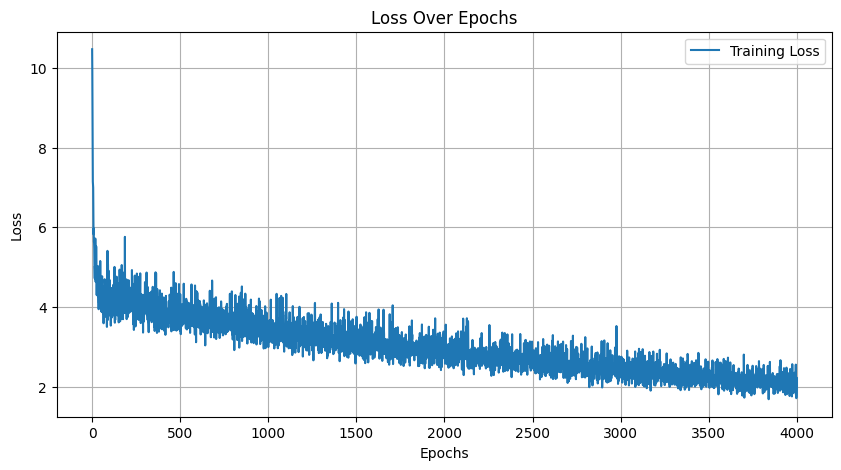

In [ ]:
import matplotlib.pyplot as plt

# Assuming plot_loss is a list of loss values
plt.figure(figsize=(10, 5))
plt.plot(plot_loss, label='Training Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()